# Game Score Notebook

## References and Links

### All of these metrics were created and scaled to approximate a corilation to Points in a game. 
Inspired by this article I found about a metric that was developed in 2016, Dom Luszczyszyn which is intended to provide a single number that approximates a player’s performance in a given game. In that original story, he included the formula for the metric and how he arrived at it, so it’s inspired various adaptations since then.
https://hockey-graphs.com/2016/07/13/measuring-single-game-productivity-an-introduction-to-game-score/

The stats I used are goals, primary assists, secondary assists, shots on goal, blocked shots, penalty differential, faceoffs, 5-on-5 corsi differential, 5-on-5 goal differential.

Player Game Score = (0.75 * G) + (0.7 * A1) + (0.55 * A2) + (0.075 * SOG) + (0.05 * BLK) + (0.15 * PD) – (0.15 * PT) + (0.01 * FOW) – (0.01 * FOL) + (0.05 * CF) – (0.05 * CA) + (0.15 * GF) – (0.15* GA)



## Adjusted / Simplified
- found on the blog frshice.substack.com
- Bailey Johnson created her simplified version to work on college hockey data because not all of the factors (specifically the defensive portion of the Corsi Metric) is not track or is not available for NCAA games

### Original
For clarity’s sake, this was my original formula after removing stats I didn’t have access to from Dom’s: Player Game Score = (0.75*G)+(0.7*A1)+(0.55*A2)+(0.075*SOG)+(0.05*BLK)+(0.01*FOW)–(0.01*FOL)+(0.15*GF)–(0.15*GA)

### Bailey Final
- I also followed Shawn’s method from his NWHL game score work and used league-wide power-play percentage to weight the impact of taking a penalty.

- Dom scaled his formula down 75% to make the game scores roughly equivalent to points so people would be familiar with what the game score represented, and I kept to that methodology here because I used some of the same weights he did. Also keep in mind that the goals for and goals against are just goals scored at even strength — it does not include special teams, empty-net or extra-attacker goals.

Player Game Score = (G*0.75)+(A1*0.715)+(A2*0.555)+(SOG*0.075)+(BLK*0.05)+(FOW*0.01)-(FOL*0.01)+(GF*0.15)-(GA*0.15)-(PNT*0.138)

### PNT*.138
- FROM SOURCE: I took the frequency of powerplay goals to penalties, otherwise known as PP%. (https://hockey-graphs.com/2018/03/22/an-introduction-to-nwhl-game-score/)
- this is her attempt to account for penalties - CHN NCAA stats don't include penalties drawn 
- PNT is penalties taken so I will want to grab the penalty incidents, not the minutes. 
- The 0.138 factor come from the league's power play percentage 
    - Want to use a static figure like overall average PP % for entire NCAA 
        - could update it to be dynamic and create a new average every time the data is called

        - IDEA: Could create a custom factor for each team in each game 
            - teams power play effectiveness can vary greatly, as can a teams PK%
            - Take the each teams previous success on PP or even on both PP and PK
            - Compare to NCAA wide average
            - get a factor that could be used and could scale the danger of taking a penalty based on how good the opponent is on PP or how poor your team is on PP


In [11]:
## Blocking out the Game Score formula

#### METRIC Formula
# 
# METRIC = SCORE [ (Goals*0.75) + (Assist1*0.715) + (Assist2*0.555) ] 
#               + SHOTS [ (Shot_On_Net*0.075) + (Shots_Off_Net*0.075) - (Shots_Blocked*0.075) ]
#               + FACEOFFS [ (Faceoff_Wins*0.01) - (Faceoff_Losses*0.01) ]
#               + TEAM [ (Goals_For_Team*0.15) + (Goals_Against_Team*0.15) ]
#               -  [ (Penalties_Taken * Overall_PP_Success_Rate) ]

# Map to each factor in the Game_Stats Database

## Calculating a Game Score for each player on each team for each game
Each Game has a unique Game_ID column in every relevant table

scoring_summary table
    Goals - in scoring_summary - count of player's name in Player Column
    Assist1 - scoring_summary - Count in Assist1
    Assist2 - scoring_summary - Count in Assist2


abdvanced_metrics_combined table
    Shots_On_Net -  - EVEN_Saved + EVEN_Goals
    Shots_Off_Net = EVENE_Miss
    Shots_Blocked = EVEN_Block

    Defensive_Blocks = D_Blocks

player_stats
    Faceoff_Wins = FO_W
    Faceoff_Loses = FO_L

### This takes into account team goals for and goals against but only counts Even strength goals in close games (+/- 1)
- can get it from the advanced metrics combined

advanced_metrics_
    Goals_For_Team = SUM of CLOSE_Goals grouped by Team -NOTE
#### NOTE- need to filter out any rows in the advanced_metrics_combined with player = 'TOTAL'
    Goals_Against_Team - do the same but for the opposing team - if Game_ID matches and Team =/= the player's team

penalty_summary
    Penalties_Taken = Count of Player's name in 



In [12]:

import sqlite3
import pandas as pd
import numpy as np

import sqlite3

db_path ='../data/2023_YTD_Game_Stats_NEW.db'
conn = sqlite3.connect(db_path)


# Connect to the provided database

cursor = conn.cursor()

# Retrieve the list of tables in the database
tables = cursor.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
tables = [table[0] for table in tables]

# Retrieve the columns from each table to get a better understanding of the data structure
table_columns = {}
for table in tables:
    columns = cursor.execute(f"PRAGMA table_info({table});").fetchall()
    table_columns[table] = [column[1] for column in columns]

# table_columns


# Create an empty dataframe to store the data
compiled_df = pd.DataFrame()

## Get Shot Data

In [13]:
# Update the code to clean the 'advanced_metrics_combined' table by removing 'TOTAL' rows

# Load the 'advanced_metrics_combined' table into a DataFrame excluding 'TOTAL' rows
df_amc = pd.read_sql("SELECT * FROM advanced_metrics_combined WHERE player != 'TOTAL'", conn)

# Convert columns to numeric for calculations (replacing empty strings with 0)
columns_to_convert = ['EVEN_Saved', 'EVEN_Goals', 'EVEN_Miss', 'EVEN_Block', 'D_Blocks']
for col in columns_to_convert:
    df_amc[col] = pd.to_numeric(df_amc[col].replace('', '0'))

# Calculate required columns
df_amc['Shots_On_Net'] = df_amc['EVEN_Saved'] + df_amc['EVEN_Goals']
df_amc['Shots_Off_Net'] = df_amc['EVEN_Miss']
df_amc['Shots_Blocked'] = df_amc['EVEN_Block']
df_amc['Defensive_Blocks'] = df_amc['D_Blocks']

# Create a DataFrame with only the desired columns
shots_df = df_amc[['Player', 'Home/Away', 'Shots_On_Net', 'Shots_Off_Net', 'Shots_Blocked', 'Defensive_Blocks', 'Game_ID']]

# Display the column names of the shots_df
shots_df.columns

shots_df.head(25)

# Merge into the compiled_df
compiled_df = shots_df.copy()

compiled_df.head(25)


,Player,Home/Away,Shots_On_Net,Shots_Off_Net,Shots_Blocked,Defensive_Blocks,Game_ID
0,Harrison Roy,Away,1,2,1,0,2023-10-07-Lake Superior-Michigan State
1,John Herrington,Away,4,0,0,0,2023-10-07-Lake Superior-Michigan State
2,Tyler Williams,Away,4,0,0,0,2023-10-07-Lake Superior-Michigan State
3,Artyom Borshyov,Away,2,1,1,0,2023-10-07-Lake Superior-Michigan State
4,Sasha Teleguine,Away,0,1,2,2,2023-10-07-Lake Superior-Michigan State
5,Grant Hindman,Away,2,1,0,2,2023-10-07-Lake Superior-Michigan State
6,Reagan Milburn,Away,1,1,0,0,2023-10-07-Lake Superior-Michigan State
7,Nate Schweitzer,Away,3,0,0,0,2023-10-07-Lake Superior-Michigan State
8,Carter Batchelder,Away,2,0,0,1,2023-10-07-Lake Superior-Michigan State
9,Evan Bushy,Away,2,0,0,0,2023-10-07-Lake Superior-Michigan State


# Get Goal, Assist1 and Assist2
- Working

In [14]:
# Separately calculate Goals, Assist1, and Assist2

# Goals
goals_df = pd.read_sql("""
SELECT 
    Player,
    Game_ID,
    COUNT(Player) AS Goals
FROM 
    scoring_summary
GROUP BY 
    Player, Game_ID;
""", conn)

# Assist1
assist1_df = pd.read_sql("""
SELECT 
    Assist1 AS Player,
    Game_ID,
    COUNT(Assist1) AS Assist1
FROM 
    scoring_summary
WHERE 
    Assist1 IS NOT NULL AND Assist1 != ''
GROUP BY 
    Assist1, Game_ID;
""", conn)

# Assist2
assist2_df = pd.read_sql("""
SELECT 
    Assist2 AS Player,
    Game_ID,
    COUNT(Assist2) AS Assist2
FROM 
    scoring_summary
WHERE 
    Assist2 IS NOT NULL AND Assist2 != ''
GROUP BY 
    Assist2, Game_ID;
""", conn)


# goals_df.head(25)
# Merge the dataframes together
merged_df = goals_df.merge(assist1_df, on=['Player', 'Game_ID'], how='outer')
merged_df = merged_df.merge(assist2_df, on=['Player', 'Game_ID'], how='outer')

# Fill NaN values with 0
merged_df = merged_df.fillna(0)

# Convert columns to int
merged_df['Goals'] = merged_df['Goals'].astype(int)
merged_df['Assist1'] = merged_df['Assist1'].astype(int)
merged_df['Assist2'] = merged_df['Assist2'].astype(int)

# # Soft by Player
merged_df = merged_df.sort_values(by=['Player'])

# # Display the first few rows
merged_df.head(20)

# histogram of the merge_df
# merged_df.hist()

# Merge into the compiled_df
compiled_df = compiled_df.merge(merged_df, on=['Player', 'Game_ID'], how='outer', indicator=True)

compiled_df.head(25)

# Histogram of the compiled_df
# compiled_df.hist()

,Player,Home/Away,Shots_On_Net,Shots_Off_Net,Shots_Blocked,Defensive_Blocks,Game_ID,Goals,Assist1,Assist2,_merge
0,Harrison Roy,Away,1.0,2.0,1.0,0.0,2023-10-07-Lake Superior-Michigan State,NaN,NaN,NaN,left_only
1,Harrison Roy,Home,1.0,2.0,1.0,0.0,2023-10-07-Lake Superior-Michigan State,NaN,NaN,NaN,left_only
2,John Herrington,Away,4.0,0.0,0.0,0.0,2023-10-07-Lake Superior-Michigan State,NaN,NaN,NaN,left_only
3,John Herrington,Home,4.0,0.0,0.0,0.0,2023-10-07-Lake Superior-Michigan State,NaN,NaN,NaN,left_only
4,Tyler Williams,Away,4.0,0.0,0.0,0.0,2023-10-07-Lake Superior-Michigan State,NaN,NaN,NaN,left_only
5,Tyler Williams,Home,4.0,0.0,0.0,0.0,2023-10-07-Lake Superior-Michigan State,NaN,NaN,NaN,left_only
6,Artyom Borshyov,Away,2.0,1.0,1.0,0.0,2023-10-07-Lake Superior-Michigan State,NaN,NaN,NaN,left_only
7,Artyom Borshyov,Home,2.0,1.0,1.0,0.0,2023-10-07-Lake Superior-Michigan State,NaN,NaN,NaN,left_only
8,Sasha Teleguine,Away,0.0,1.0,2.0,2.0,2023-10-07-Lake Superior-Michigan State,NaN,NaN,NaN,left_only
9,Sasha Teleguine,Home,0.0,1.0,2.0,2.0,2023-10-07-Lake Superior-Michigan State,NaN,NaN,NaN,left_only


array([[<Axes: title={'center': 'Shots_On_Net'}>,
        <Axes: title={'center': 'Shots_Off_Net'}>,
        <Axes: title={'center': 'Shots_Blocked'}>],
       [<Axes: title={'center': 'Defensive_Blocks'}>,
        <Axes: title={'center': 'Goals'}>,
        <Axes: title={'center': 'Assist1'}>],
       [<Axes: title={'center': 'Assist2'}>,
        <Axes: title={'center': 'Faceoff_Wins'}>,
        <Axes: title={'center': 'Faceoff_Losses'}>]], dtype=object)

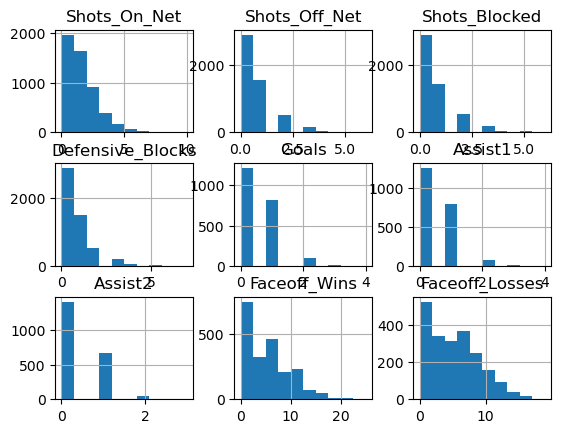

In [15]:
# Calculate Faceoff Metrics for each player in each game

query_faceoff_metrics = """
SELECT 
    Player,
    Game_ID,
    FOW AS Faceoff_Wins,
    FOL AS Faceoff_Losses
FROM 
    player_stats;
"""

# Create a DataFrame with the results



faceoff_metrics_data = cursor.execute(query_faceoff_metrics).fetchall()

# Preview the first few rows of the result
faceoff_metrics_data[:5]

# Merge into the compiled_df
faceoff_metrics_df = pd.DataFrame(faceoff_metrics_data, columns=['Player', 'Game_ID', 'Faceoff_Wins', 'Faceoff_Losses'])

# Drop old indicator column to make way for new one
compiled_df = compiled_df.drop(columns=['_merge'])
compiled_df = compiled_df.merge(faceoff_metrics_df, on=['Player', 'Game_ID'], how='outer', indicator=True)

# Histogram of the compiled_df
compiled_df.hist()

# compiled_df.head(25)

In [16]:
# # Calculate Team Goals Metrics for each player in each game

# query_team_goals = """
# WITH TeamGoals AS (
#     SELECT 
#         Game_ID,
#         Team,
#         SUM(CLOSE_Goals) AS Goals_For_Team
#     FROM 
#         advanced_metrics_combined
#     WHERE 
#         Player != 'TOTAL'
#     GROUP BY 
#         Game_ID, Team
# ),
# OpponentGoals AS (
#     SELECT 
#         a.Game_ID,
#         a.Team AS Player_Team,
#         b.Team AS Opponent_Team,
#         b.Goals_For_Team AS Goals_Against_Team
#     FROM 
#         TeamGoals a
#     JOIN 
#         TeamGoals b ON a.Game_ID = b.Game_ID AND a.Team != b.Team
# )
# SELECT 
#     amc.Player,
#     amc.Game_ID,
#     amc.Team,
#     tg.Goals_For_Team,
#     og.Goals_Against_Team
# FROM 
#     advanced_metrics_combined amc
# JOIN 
#     TeamGoals tg ON amc.Game_ID = tg.Game_ID AND amc.Team = tg.Team
# JOIN 
#     OpponentGoals og ON amc.Game_ID = og.Game_ID AND amc.Team = og.Player_Team
# WHERE 
#     amc.Player != 'TOTAL';
# """

# # Create a Pandas DataFrame from the results
# team_goals_df = pd.read_sql_query(query_team_goals, conn)



# Preview the first few rows of the result
# team_goals_data[:5]


### Overall PP Success

In [17]:
### Find the Overall Power Play Success rate for the entire database

# Count the total number of Power Play (PP) goals from the scoring_summary table.
pp_goals_count = cursor.execute("SELECT COUNT(*) FROM scoring_summary WHERE PP != '';").fetchone()[0]

# Count the total number of Power Plays from the penalty_summary table.
total_pp_count = cursor.execute("SELECT COUNT(*) FROM penalty_summary;").fetchone()[0]

# Calculate the Power Play success rate.
pp_success_rate = pp_goals_count / total_pp_count


## OVERALL NCAA WIDE POWER PLAY SUCCESS RATE TO USE IN FACTOR
pp_success_rate


0.24649176327028677

# Team Goals Component

In [18]:

# NOT WORKING
# # Adjusting the team_goals_query with the updated approach
# team_goals_query_updated = """
# WITH TeamGoals AS (
#     SELECT 
#         Game_ID,
#         Team,
#         SUM(Player_Goals) AS Goals_For_Team
#     FROM 
#         scoring_summary
#     WHERE 
#         Player != 'TOTAL'
#     GROUP BY 
#         Game_ID, Team
# )

# SELECT 
#     amc.Game_ID,
#     amc.Player,
#     amc.Team,
#     COALESCE(TeamGoals.Goals_For_Team, 0) AS Goals_For_Team,
#     COALESCE((SELECT SUM(Player_Goals) FROM scoring_summary ss2 
#               WHERE ss2.Game_ID = amc.Game_ID AND ss2.Team != amc.Team AND ss2.Player != 'TOTAL'), 0) AS Goals_Against_Team
# FROM 
#     advanced_metrics_combined amc
# LEFT JOIN 
#     TeamGoals ON amc.Game_ID = TeamGoals.Game_ID AND amc.Team = TeamGoals.Team
# """

# # Execute the updated query to fetch the data
# team_comp_data_df_updated = pd.read_sql(team_goals_query_updated, conn)

# # Display the shape and the first few rows
# team_comp_data_df_updated.shape, team_comp_data_df_updated.head(25)


((5434, 5),
                                     Game_ID             Player           Team  \
 0   2023-10-07-Lake Superior-Michigan State       Harrison Roy  Lake Superior   
 1   2023-10-07-Lake Superior-Michigan State    John Herrington  Lake Superior   
 2   2023-10-07-Lake Superior-Michigan State     Tyler Williams  Lake Superior   
 3   2023-10-07-Lake Superior-Michigan State    Artyom Borshyov  Lake Superior   
 4   2023-10-07-Lake Superior-Michigan State    Sasha Teleguine  Lake Superior   
 5   2023-10-07-Lake Superior-Michigan State      Grant Hindman  Lake Superior   
 6   2023-10-07-Lake Superior-Michigan State     Reagan Milburn  Lake Superior   
 7   2023-10-07-Lake Superior-Michigan State    Nate Schweitzer  Lake Superior   
 8   2023-10-07-Lake Superior-Michigan State  Carter Batchelder  Lake Superior   
 9   2023-10-07-Lake Superior-Michigan State         Evan Bushy  Lake Superior   
 10  2023-10-07-Lake Superior-Michigan State       Dawson Tritt  Lake Superior   
 11 

,Goals_For_Team,Goals_Against_Team
count,5434.000000,5434.000000
mean,1.970556,9.013986
std,4.303019,6.518785
min,0.000000,0.000000
25%,0.000000,5.000000
50%,0.000000,8.000000
75%,2.000000,12.000000
max,43.000000,43.000000


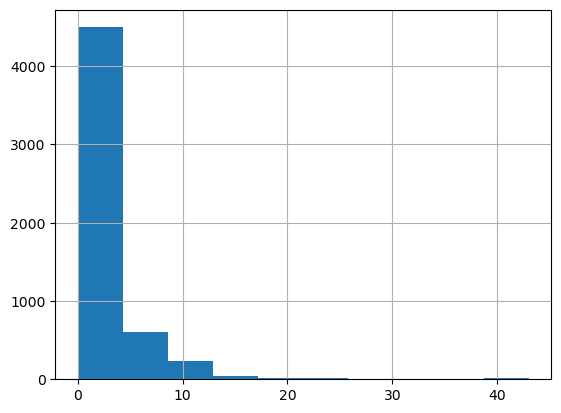

In [19]:
# ## Histogram of the Goals_For_Team
# team_comp_data_df_updated['Goals_For_Team'].hist()

# # Describe the dataframe
# team_comp_data_df_updated.describe()

(309, 4)


<Axes: >

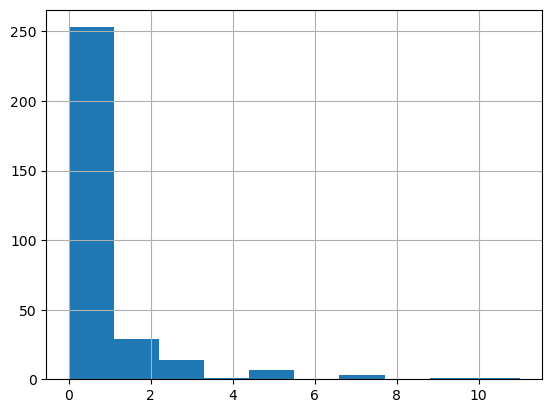

In [23]:
# Adjusting the TEAM component query
team_goals_query = """
    SELECT 
        ss.Game_ID,
        ss.Player,
        SUM(CASE WHEN ss.Team = amc.Team THEN ss.Player_Goals ELSE 0 END) AS Goals_For_Team,
        SUM(CASE WHEN ss.Team != amc.Team THEN ss.Player_Goals ELSE 0 END) AS Goals_Against_Team
    FROM scoring_summary ss
    JOIN advanced_metrics_combined amc ON ss.Game_ID = amc.Game_ID AND REPLACE(ss.Player, '\xa0', ' ') = REPLACE(amc.Player, '\xa0', ' ')
    GROUP BY ss.Game_ID, ss.Player
"""

# Create a dataframe with the TEAM component data
team_comp_data_df = pd.read_sql(team_goals_query, conn)

print(team_comp_data_df.shape)  

# Dort the dataframe by Game_ID and Player
team_comp_data_df = team_comp_data_df.sort_values(by=['Game_ID', 'Player'])

# Preview the first few rows of the dataframe
team_comp_data_df.head(25)



# # Histogram of Goals_For_Team
team_comp_data_df['Goals_For_Team'].hist()

# team_comp_data_df['Goals_Against_Team'].describe()


In [ ]:
game_score_df.head()

# game_score_df['Goals_For_Team'].hist()

game_score_df['Goals'].hist()

# game_score_df.sample(20)

# Penalty Component

array([[<Axes: title={'center': 'Shots_On_Net'}>,
        <Axes: title={'center': 'Shots_Off_Net'}>,
        <Axes: title={'center': 'Shots_Blocked'}>],
       [<Axes: title={'center': 'Defensive_Blocks'}>,
        <Axes: title={'center': 'Goals'}>,
        <Axes: title={'center': 'Assist1'}>],
       [<Axes: title={'center': 'Assist2'}>,
        <Axes: title={'center': 'Faceoff_Wins'}>,
        <Axes: title={'center': 'Faceoff_Losses'}>],
       [<Axes: title={'center': 'Penalties_Taken_x'}>,
        <Axes: title={'center': 'Penalties_Taken_y'}>, <Axes: >]],
      dtype=object)

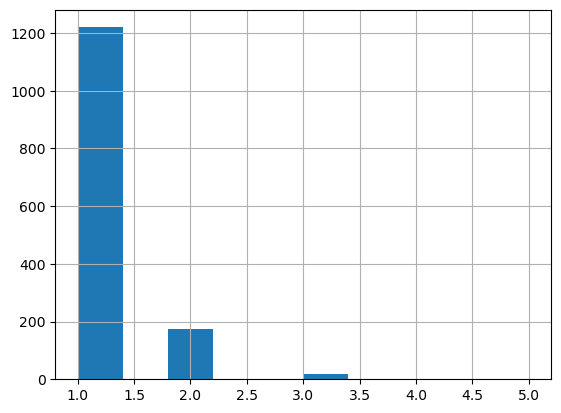

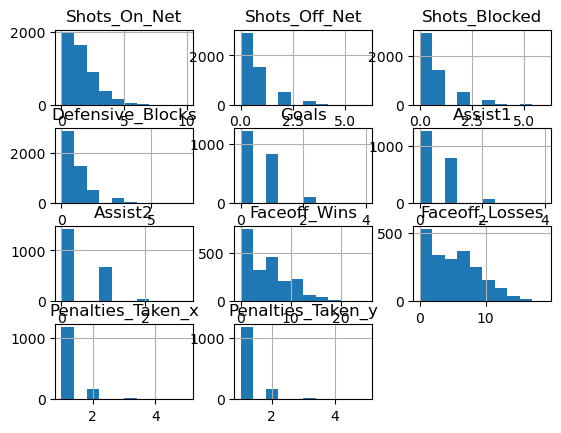

In [29]:
## Penalty Component

# Count the number of penalties taken by each player in each game
penalty_count_query = """
SELECT
    Game_ID,
    Player,
    COUNT(*) AS Penalties_Taken
FROM
    penalty_summary
WHERE
    Player != 'TOTAL'
GROUP BY
    Game_ID, Player;
"""

# Create a DataFrame with the results
penalty_count_df = pd.read_sql(penalty_count_query, conn)

# Preview the first few rows of the result
penalty_count_df.head()

penalty_count_df['Penalties_Taken'].hist()

# penalty_count_df.describe()

# merge it into the compiled_df
compiled_df = compiled_df.merge(penalty_count_df, on=['Player', 'Game_ID'], how='left')

compiled_df.head(25)


compiled_df.hist()

# game_score_df['Penalties_Taken'] = game_score_df['Game_ID'].apply(lambda x: cursor.execute(f"SELECT COUNT(*) FROM penalty_summary WHERE Game_ID = '{x}';").fetchone()[0])

# game_score_df['Overall_PP_Success_Rate'] = pp_success_rate

# game_score_df['Penalty_Component'] = game_score_df['Penalties_Taken'] * game_score_df['Overall_PP_Success_Rate']

# game_score_df.head()

## Where to find these values in my DB
scoring_summary
    - Goals
    -First Assist
    -Second Assist

player_stats
    - Shots on Goal
    - FOW
    - FOL
    - PIM 
        - (Maybe worth weighting differently based on period and time it was taken)
        - Penalty late in a close game hurts a team more than something taken in the first perios
        - a penalty that is taken when already short handed hurts much more than one 5-on-5
            - I should be able to seperate out these types of occurences in the data from penalty_summary

CAN'T Get Penalties Drawn from current data

### Formulating the final 3 factors
GA & GF should only use even strength goals - need to figure out how to filter those

Shots blocked (overall - defensive) can be found in advanced metrics as well as SOG, Offensive shots blocked and shots missed net for each of these situations (total, close, even and PP)





## Corsi Differnal = Corsi For - Corsi Defence
Corsi is an advanced statistic used in the game of ice hockey to measure shot attempt differential while at even strength play. This includes shots on goal, missed shots on goal, and blocked shot attempts towards the opposition's net minus the same shot attempts directed at your own team's net.

History
The Corsi number was named by Tim Barnes, a financial analyst from Chicago working under the pseudonym Vic Ferrari. He had heard former Buffalo Sabres general manager Darcy Regier talking about shot differential on the radio, and then proceeded to develop a formula to accurately display shot differential. Ferrari originally wanted to name it the Regier number, but he didn't think it sounded right. He then considered calling it the Ruff number after former Buffalo Sabres head coach Lindy Ruff but he didn't think that was appropriate either. Ferrari ended up searching Buffalo Sabres staff, found a picture of Jim Corsi, and chose his name because he liked Corsi's mustache.[1]

Formulae
Corsi For (CF) = Shot attempts for at even strength: Shots + Blocks + Misses[2]
Corsi Against (CA) = Shot attempts against at even strength: Shots + Blocks + Misses
Corsi (C) = CF - CA
Corsi For % (CF%) = CF / (CF + CA)
Corsi For % Relative (CF% Rel) = CF% - CFOff%
Corsi Per 60 Minutes at Even Strength (C/60) = (CF - CA) * 60 / TOI
Relative Corsi per 60 Minutes at Even Strength (Crel/60) = CF/60 - CFoff/60 = On-Ice Corsi For / 60 Minutes - Off-Ice Corsi For / 60 Minutes